In [13]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

# from model import vit_base_patch16_224
from timm.models import vit_base_patch16_224

In [14]:
# model = vit_base_patch16_224(pretrained=True)
model = torch.load('/home/ibrahimalmakky/Documents/Projects/XAIM/temp/vit_base_patch16_224_in21k_test-accuracy_0.96_chest.pth')
model = model.cpu()

In [15]:
model.blocks[11].attn

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [16]:
image_folder = "/nvme/datasets/TB_data/testing/Normal"
image_files = [
        f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")
    ]

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation((90,90)),
        transforms.Resize((224, 224)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ]
)

image_path = os.path.join(image_folder, image_files[0])
image = Image.open(image_path)
img = transform(image)
img = img.unsqueeze(0)

In [17]:
# img = torch.FloatTensor(size=(1,3,224,224))
patch_size = 16

In [23]:
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h = model.blocks[6].attn.attn_drop.register_forward_hook(getActivation("attn"))

model.eval()
out = model(img)

In [24]:
print(activation['attn'].shape)

torch.Size([1, 12, 197, 197])


In [25]:
attentions = activation['attn']
nh = attentions.shape[1]
# keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

attentions = attentions.reshape(nh, w_featmap, h_featmap)

attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions = attentions.transpose(0,2,1)

In [26]:
attentions.shape

(12, 224, 224)

In [27]:
def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()

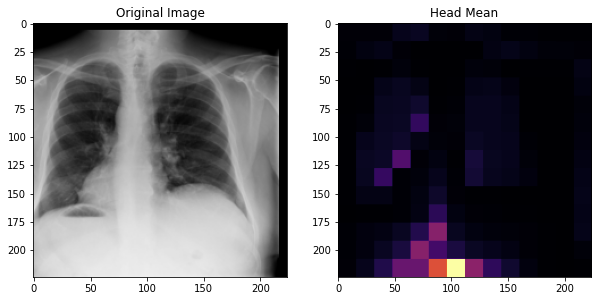

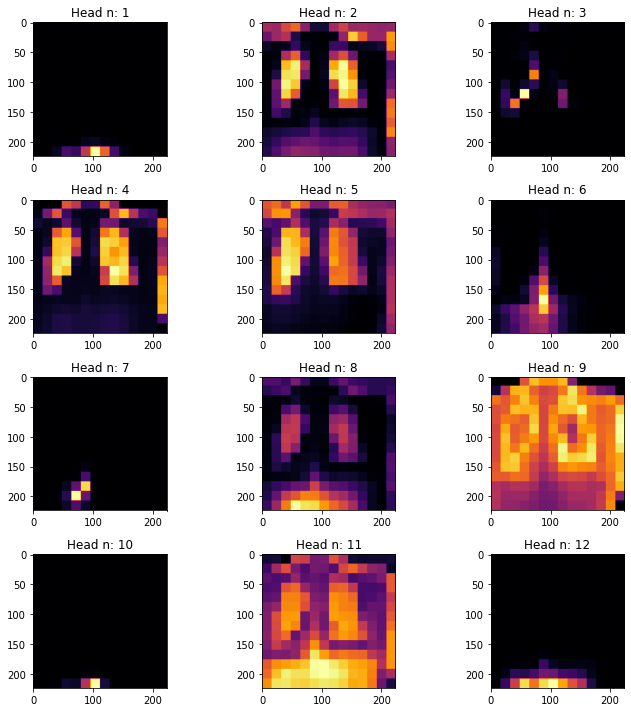

In [28]:
plot_attention(img[0].transpose(0,2), attentions)